In [1]:
%matplotlib inline

import random
import numpy as np

from drone import FireGrid, ScoutDrone, SuppressorDrone
from env import FireFightingEnv

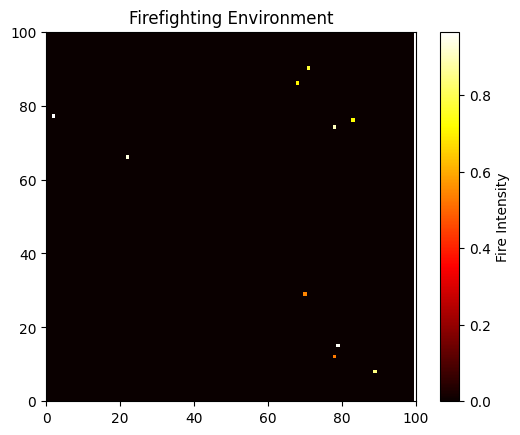

In [2]:
np.random.seed(1)
random.seed(1)

test_env = FireFightingEnv(render_mode='hum', num_scouts=0, num_suppresors=0)
test_env.render()

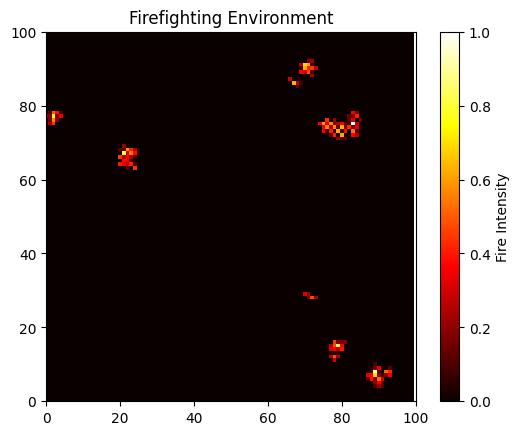

In [ ]:
for _ in range(100):
    test_env.fire_grid.spread_fire()

# test_env.render()

In [4]:
np.random.seed(5)
random.seed(5)

grid_size = (50, 50)
env = FireFightingEnv(render_mode='human', num_scouts=5, num_suppresors=5)
obs, info = env.reset()

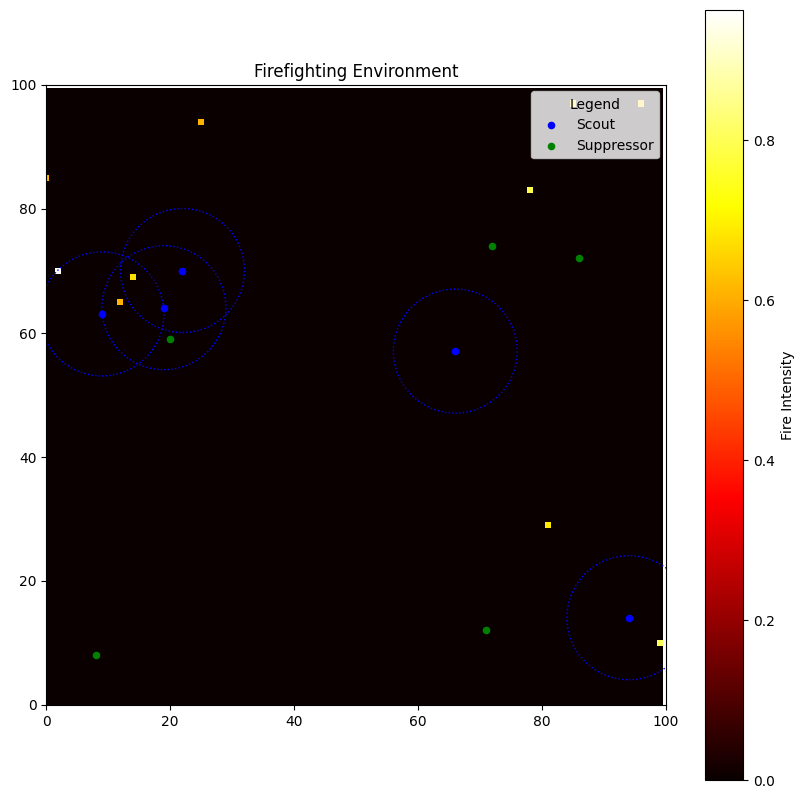

<Figure size 640x480 with 0 Axes>

In [5]:
env.render()

In [10]:
local_fire_map = env.agent_map['scout_1'].sense_fire(env.fire_grid)
hotspot_indices = np.where(local_fire_map > 0)
hotspot_indices


(array([8]), array([17]))

In [44]:
len(hotspot_indices)

2

In [11]:
env.agent_map['scout_1'].position

array([92, 20])

In [12]:
fires = np.where(env.fire_grid.grid > 0, 1, 0).astype(np.uint8)
np.argwhere(fires > 0)

array([[ 8, 85],
       [10, 33],
       [20, 30],
       [71, 17],
       [73, 97],
       [78, 75],
       [86, 72],
       [88, 92],
       [90, 27],
       [90, 87]])

In [14]:
drone = env.agent_map['scout_1']
x, y = drone.position

offset_x = max(0, x - drone.sensing_radius)
offset_y = max(0, y - drone.sensing_radius)

# Convert local hotspot coordinates to global coordinates
visible_hotspots = np.array([
    [hotspot_indices[0][i] + offset_x, hotspot_indices[1][i] + offset_y]
    for i in range(len(hotspot_indices[0]))
])
visible_hotspots

array([[90, 27]])

In [ ]:
intensities = env.fire_grid.grid[visible_hotspots[:, 0], visible_hotspots[:, 1]]
intensities

(array([0.84987918]), np.float64(0.8498791800104656))

In [18]:
target_position = visible_hotspots[np.argmax(intensities)]
target_position

array([90, 27])

In [30]:
direction = target_position - drone.position
distance = np.linalg.norm(direction)
if distance > 1e-3:  # avoid division by zero
    velocity = direction
    drone.velocity = velocity
else:
    drone.velocity = np.zeros(2)

print(f"Move from {drone.position} to {target_position}")
print(f"Velocity: {drone.velocity}")

Move from [92 20] to [90 27]
Velocity: [-2  7]


In [22]:
vx, vy = drone.velocity
angle = np.arctan2(vy, vx)
action = int(((angle + np.pi) / (2 * np.pi / 8)) % 8)

action

6

In [34]:
angle = np.arctan2(1, 0)
angle = (angle + 360) % 360  # Normalize to [0, 360)

# Each octant is 45 degrees
index = int(((angle + 22.5) % 360) // 45)
action

6

In [39]:
angles = [
    (0, 1),   # North
    (1, 1),   # North-East
    (1, 0),   # East
    (1, -1),  # South-East
    (0, -1),  # South
    (-1, -1), # South-West
    (-1, 0),  # West
    (-1, 1)   # North-West
]

for vx, vy in angles:
    angle = np.arctan2(vy, vx)
    action = int(((angle + np.pi) / (2 * np.pi / 8)) % 8)
    print(f"Velocity: ({vx}, {vy}) -> Action: {action}")

Velocity: (0, 1) -> Action: 6
Velocity: (1, 1) -> Action: 5
Velocity: (1, 0) -> Action: 4
Velocity: (1, -1) -> Action: 3
Velocity: (0, -1) -> Action: 2
Velocity: (-1, -1) -> Action: 1
Velocity: (-1, 0) -> Action: 0
Velocity: (-1, 1) -> Action: 7


In [43]:
fire_locations = np.argwhere(env.fire_grid.grid > 0)
env.fire_grid.grid[drone.position[0], drone.position[1]]

np.float64(0.0)